<a href="https://colab.research.google.com/github/GoginikariTharunTeja/NLP/blob/main/sentiment_tharun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#import libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
df=pd.read_csv('/content/drive/MyDrive/NLP/emotion_dataset_2 (1).csv') #Text data
#EMBEDDING_FILE= f'C:/Users/nakka/Documents/python/NLP/glove.6B/glove.6B.100d.txt' #GloVe file path
df.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


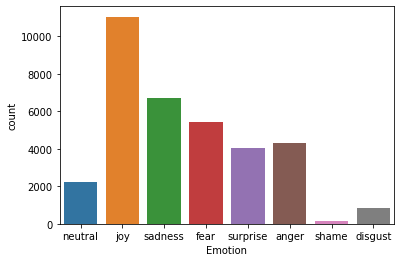

In [13]:
#Target Classes
sns.countplot(df['Emotion']) 

In [14]:
df=df.dropna() #Drop columns with NA values
X=df.drop('Emotion',axis=1) #Input
y=df['Emotion'] #Output

In [15]:
messages=X.copy()
messages.reset_index(inplace=True) #Drop NA may cause inconsistency in index

In [16]:
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
corpus[:10]

['',
 'sage act upgrad list tommorow',
 'way homegirl babi funer man hate funer realli show bless',
 'eye true hazel eye brilliant regular featur open counten complexion oh bloom full health pretti height size firm upright figur health mere bloom air head glanc one hear sometim child pictur health alway give idea complet pictur grown health loveli',
 'iluvmiasanto ugh babe hugggzzz u babe naamaz nga ako e babe e despit nega ma pinaramdam fil ko ang',
 'expect extrem import phonecal minut terror opportun',
 'couldnt wait see live miss nh wasnt pain enuf suraj perform last gig delhi',
 'maken tip stop op een moment dat je het hele project wel ziet zitten nu du derestkomtlaterwel',
 'en dan krijg je ff een cadeautj van een tweep melik',
 'drummer boy bij op verzoek van biemoosterhof frankcornet welk uitvoer van wie']

In [18]:
# code for Glove word embedding  
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
  
# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
#print("Dictionary is = ", tokenizer.word_index)
  
# download glove and unzip it in Notebook.
# http://nlp.stanford.edu/data/glove.6B.zip

def embedding_for_vocab(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab
    
# matrix for vocab: word_index
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab('/content/drive/MyDrive/NLP/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)
print("Dense vector for first word is => ", embedding_matrix_vocab[1])

Number of unique words in dictionary= 28585
Dense vector for first word is =>  [ 7.36779999e-03  6.25320002e-02 -9.74320024e-02  2.82889992e-01
  1.79069996e-01  1.55630007e-01 -6.00220002e-02 -1.87059999e-01
  2.52200007e-01 -1.43659997e+00  1.83960006e-01 -4.11540002e-01
 -2.47209996e-01 -2.89240003e-01  2.27329999e-01  9.33770016e-02
 -1.30050004e-01 -2.37379998e-01  2.97340006e-01  3.92870009e-01
  2.46020004e-01  1.37779996e-01  5.04310012e-01 -1.96400002e-01
 -1.96079999e-01  3.03199999e-02  1.74940005e-01  1.50950000e-01
 -9.30700004e-02 -8.15420002e-02  1.37449995e-01  2.66009986e-01
  2.61099994e-01 -3.29400003e-01 -1.25039995e+00  3.54400016e-02
 -9.02659968e-02  2.11370006e-01 -2.44629994e-01 -1.05710000e-01
 -1.61099993e-02 -5.27719975e-01 -2.95199990e-01 -1.26179993e-01
 -2.51940012e-01 -2.86819991e-02  6.00709975e-01  5.56989983e-02
 -5.31440005e-02  9.40390006e-02 -7.34390020e-02 -1.37180001e-01
 -1.90239996e-02 -1.97290003e-01 -2.43379995e-01  2.57360011e-01
 -8.5362002

In [19]:
#Contains the pretrained GloVe weights for the words
voc_size=len(embedding_matrix_vocab)
print(voc_size)

28586


In [20]:
#One hot representation for input
onehot_repr=[one_hot(words, voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...  2128  3375 15694]
 [    0     0     0 ...  6215 18699 21922]
 ...
 [    0     0     0 ...  1430  8406 18438]
 [    0     0     0 ... 11375 27693 18941]
 [    0     0     0 ...  1967 22673  6315]]


In [21]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 3 5 ... 0 2 5]


In [22]:
X_final.shape,y_final.shape

((34792, 100), (34792,))

In [23]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=21)

In [26]:
# Creating model
model=Sequential()
model.add(Embedding(voc_size, embedding_dim, weights=[embedding_matrix_vocab]))
model.add(Dropout(0.20))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))) #L1 regularization
model.add(Dropout(0.20))
model.add(Dense(8,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2858600   
                                                                 
 dropout_3 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [28]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=64,callbacks = [model_save])

Epoch 1/10
370/370 [==============================] - ETA: 0s - loss: 0.9169 - accuracy: 0.7664
Epoch 1: val_loss improved from inf to 1.44079, saving model to weights.h5
370/370 [==============================] - 106s 286ms/step - loss: 0.9169 - accuracy: 0.7664 - val_loss: 1.4408 - val_accuracy: 0.5772
Epoch 2/10
370/370 [==============================] - ETA: 0s - loss: 0.8561 - accuracy: 0.7866
Epoch 2: val_loss did not improve from 1.44079
370/370 [==============================] - 103s 277ms/step - loss: 0.8561 - accuracy: 0.7866 - val_loss: 1.4853 - val_accuracy: 0.5780
Epoch 3/10
370/370 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.8026
Epoch 3: val_loss did not improve from 1.44079
370/370 [==============================] - 100s 271ms/step - loss: 0.8126 - accuracy: 0.8026 - val_loss: 1.5155 - val_accuracy: 0.5703
Epoch 4/10
370/370 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.8139
Epoch 4: val_loss did not improve from 1.4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


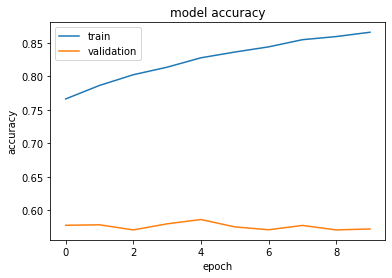

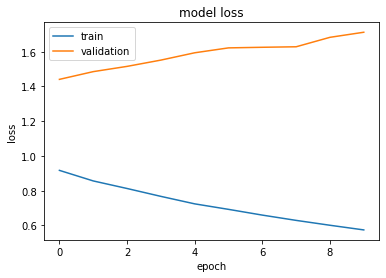

In [29]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
#Load the best weights
model.load_weights('weights.h5')

In [31]:
y_pred_test=model.predict(X_test).argmax(axis=1)  
print(y_pred_test)
y_pred_train=model.predict(X_train).argmax(axis=1)
print(y_pred_train)
y_pred_val=model.predict(X_val).argmax(axis=1)
print(y_pred_val)

218/218 [==============================] - 7s 30ms/step
[2 0 5 ... 3 2 2]
740/740 [==============================] - 23s 31ms/step
[4 3 0 ... 7 4 5]
131/131 [==============================] - 4s 29ms/step
[3 2 0 ... 7 7 5]


In [32]:
#Accuracy score
print("Training accuracy: ",accuracy_score(y_train,y_pred_train))
print("Testing accuracy: ",accuracy_score(y_test,y_pred_test))
print("Validation accuracy: ",accuracy_score(y_val,y_pred_val))

Training accuracy:  0.8331642573336715
Testing accuracy:  0.5872970254346889
Validation accuracy:  0.577245508982036


In [33]:
#Classification report
print(classification_report(y_test, y_pred_test, digits=5))

              precision    recall  f1-score   support

           0    0.46605   0.54187   0.50111       836
           1    0.00000   0.00000   0.00000       202
           2    0.67371   0.66395   0.66880      1104
           3    0.64066   0.68609   0.66260      2214
           4    0.74624   0.72141   0.73362       481
           5    0.51105   0.55765   0.53333      1327
           6    0.00000   0.00000   0.00000        23
           7    0.47967   0.38212   0.42538       772

    accuracy                        0.58730      6959
   macro avg    0.43967   0.44414   0.44060      6959
weighted avg    0.56894   0.58730   0.57670      6959



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


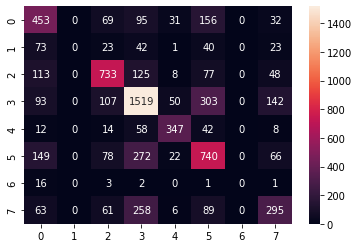

In [34]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred_test),annot=True,fmt="d"))

In [35]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'shame': 6, 'surprise': 7}


In [36]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [37]:
predict_emotion('I am very happy and joyful today')

1/1 [==============================] - 0s 36ms/step


'joy'

In [38]:
predict_emotion('today is beautiful')

1/1 [==============================] - 0s 26ms/step


'joy'

In [39]:
predict_emotion('once in a while')

1/1 [==============================] - 0s 25ms/step


'neutral'

In [40]:
predict_emotion('i almost foget hair loored looked mirror')

1/1 [==============================] - 0s 35ms/step


'fear'

In [41]:
predict_emotion('ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN I HATE FUNERALS THIS REALLY SHOWS ME HOW BLESSED I AM  ')

1/1 [==============================] - 0s 25ms/step


'sadness'

In [42]:
predict_emotion('iam scary')

1/1 [==============================] - 0s 25ms/step


'fear'

In [43]:
predict_emotion('I was riding with a friend in his car. At a speed of 120 km/h on the snow-covered motorway I would have liked to get out.')#fear

1/1 [==============================] - 0s 109ms/step


'fear'

In [44]:
predict_emotion('Few years ago my father was very ill. He stayed at a hospital for a long time. Then I experienced that terrible feeling that I might lose him.')

1/1 [==============================] - 0s 42ms/step


'sadness'

In [52]:
predict_emotion('I failed to play cricket.')


1/1 [==============================] - 0s 26ms/step


'sadness'

In [46]:
predict_emotion(' No , I just check my weight , Iam getting fatter')
#anger

1/1 [==============================] - 0s 25ms/step


'anger'

In [47]:
predict_emotion('friend was spreading negative rumours about me.')
#sadness

1/1 [==============================] - 0s 24ms/step


'sadness'

In [48]:
predict_emotion('Before giving a seminar to a rather large audience.')
#fear

1/1 [==============================] - 0s 30ms/step


'fear'

In [56]:
predict_emotion('friends dont recognize me')

1/1 [==============================] - 0s 26ms/step


'sadness'

In [57]:
predict_emotion('iam very happy to give presentation')

1/1 [==============================] - 0s 28ms/step


'joy'